# Proyecto v6: Clasificación de Revisiones Médicas con PLN y XGBoost
# ---------------------------------------------------------------------------------
# Este script aplica un modelo XGBoost a datos de texto.
# 1. Se preprocesa el texto de las revisiones médicas ('Findings').
# 2. Se convierte el texto a números usando TF-IDF.
# 3. Se combinan las características de texto con otras categóricas.
# 4. Se entrena un clasificador XGBoost para predecir la categoría del diagnóstico.
# ---------------------------------------------------------------------------------


Nota de instalacion de bibliotecas:

pip install pandas

pip install numpy

pip matplotlib

pip install seaborn

pip install nltk

pip install scikit-learn==1.6.1

pip install xgboost

In [1]:
# --- PASO 1: IMPORTACIÓN DE LIBRERÍAS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Scikit-learn para preprocesamiento, PLN y métricas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# XGBoost, nuestro modelo de clasificación
import xgboost as xgb

In [2]:
# Add this before the preprocessing section
try:
    # Test if punkt tokenizer is available
    word_tokenize("test")
    stopwords.words('english')
except (LookupError, OSError):
    print("Downloading required NLTK data...")
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')  # For newer NLTK versions


>>> Cargando y analizando 'Independent_Medical_Reviews.csv'...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
>>> Dataset cargado desde Google Drive.

--- Análisis Exploratorio de Datos (EDA) ---

Primeras 5 filas del dataset:
  Reference ID  Report Year      Diagnosis Category Diagnosis Sub Category  \
0   MN16-22639         2016              Infectious              Hepatitis   
1   MN16-22638         2016                  Mental        Eating Disorder   
2   MN16-22637         2016         Autism Spectrum         Autism-PDD-NOS   
3   EI16-22636         2016  Prevention/Good Health                    NaN   
4    EI06-5319         2006     Cardiac/Circulatory                    NaN   

                          Treatment Category  \
0                Pharmacy/Prescription Drugs   
1                    Mental Health Treatment   
2                   Autism Related Treatment   
3  Diagnostic Imaging, Screen

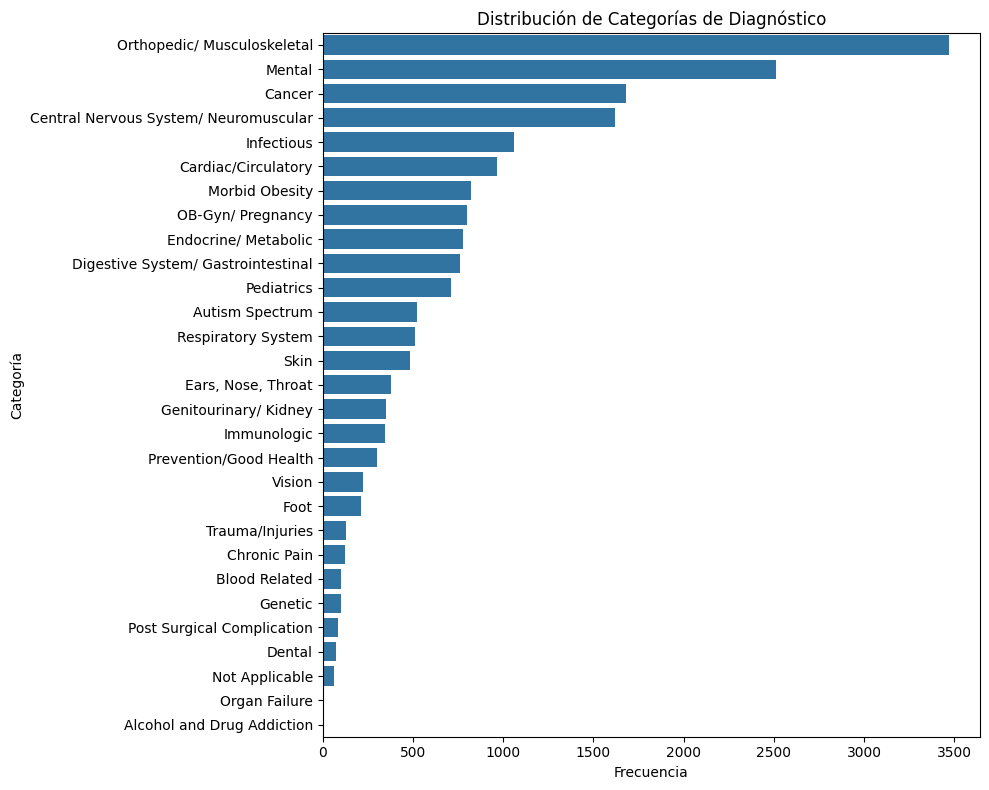

In [ ]:
# --- PASO 2: CARGA Y ANÁLISIS DEL DATASET Google colab ---
print("\n>>> Cargando y analizando 'Independent_Medical_Reviews.csv'...")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path_reviews = "/content/drive/MyDrive/IA - P&T/Proyecto/Datos/Independent_Medical_Reviews.csv" # Asegúrate de que esta sea la ruta correcta
    df = pd.read_csv(path_reviews)
    print(">>> Dataset cargado desde Google Drive.")
except Exception as e:
    print(f"ADVERTENCIA: No se pudo cargar desde Google Drive. Error: {e}")
    print("Usando ruta local. Asegúrate de que el archivo esté en el directorio.")
    try:
        df = pd.read_csv("Independent_Medical_Reviews.csv")
    except FileNotFoundError:
        print("ERROR: Archivo 'Independent_Medical_Reviews.csv' no encontrado. Deteniendo script.")
        exit()

In [ ]:
!pip install gdown

Defaulting to user installation because normal site-packages is not writeable


Version Local

In [ ]:
#Extraer el csv de Google Drive
print("\n>>> Cargando y analizando 'Independent_Medical_Reviews.csv'...")
try:
    import os
    import gdown
    id = "1ghclls4LjTlblDPyYopkxqbeW4IPgW1v"  # Independent_Medical_Reviews.csv
    path_reviews = "datos/Independent_Medical_Reviews.csv"
    gdown.download(f"https://drive.google.com/uc?id={id}", path_reviews, quiet=False)
    print(">>> Archivo descargado desde Google Drive.")
except Exception as e:
    print(f"ADVERTENCIA: No se pudo cargar desde Google Drive. Error: {e}")
    print("Usando ruta local. Asegúrate de que el archivo esté en el directorio.")
    try:
        df = pd.read_csv("Independent_Medical_Reviews.csv")
    except FileNotFoundError:
        print("ERROR: Archivo 'Independent_Medical_Reviews.csv' no encontrado. Deteniendo script.")
        exit()

In [4]:
#-- Paso 2: version local -- 
path_reviews = "datos/Independent_Medical_Reviews.csv" # Asegúrate de que esta sea la ruta correcta
df = pd.read_csv(path_reviews)


--- Análisis Exploratorio de Datos (EDA) ---

Primeras 5 filas del dataset:
  Reference ID  Report Year      Diagnosis Category Diagnosis Sub Category  \
0   MN16-22639         2016              Infectious              Hepatitis   
1   MN16-22638         2016                  Mental        Eating Disorder   
2   MN16-22637         2016         Autism Spectrum         Autism-PDD-NOS   
3   EI16-22636         2016  Prevention/Good Health                    NaN   
4    EI06-5319         2006     Cardiac/Circulatory                    NaN   

                          Treatment Category  \
0                Pharmacy/Prescription Drugs   
1                    Mental Health Treatment   
2                   Autism Related Treatment   
3  Diagnostic Imaging, Screening and Testing   
4                            Cardio Vascular   

                     Treatment Sub Category  \
0                               Anti-virals   
1  Residential Treatment Center - Admission   
2                       

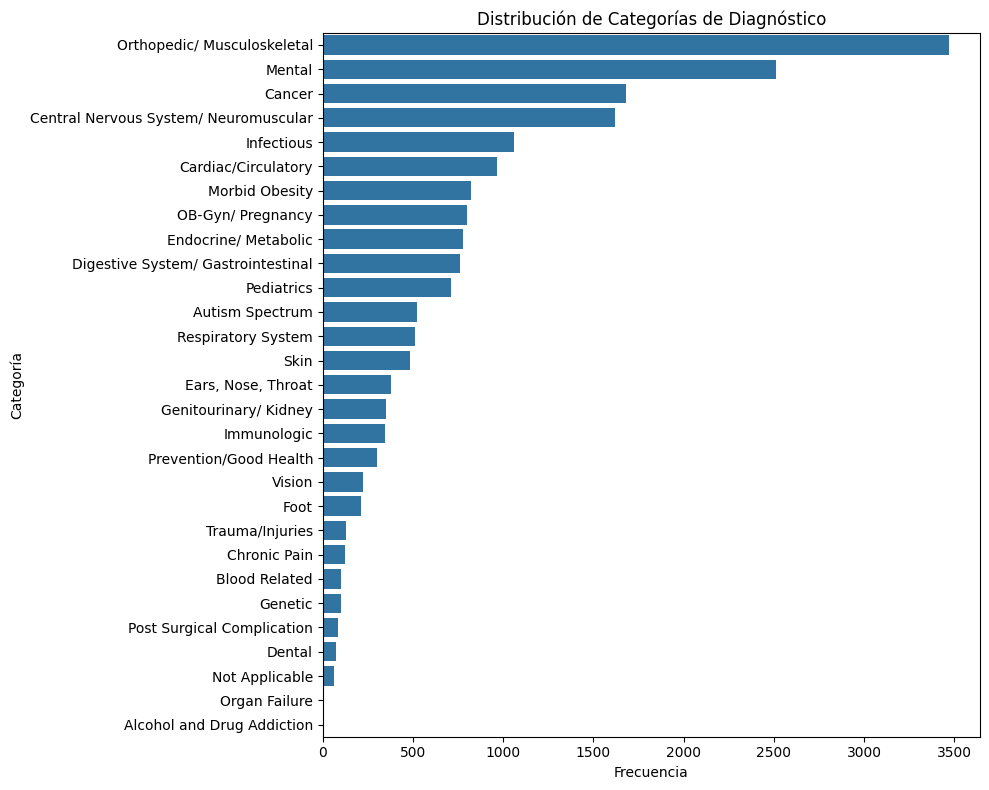

In [5]:
# Análisis Exploratorio de Datos (EDA)
print("\n--- Análisis Exploratorio de Datos (EDA) ---")
print("\nPrimeras 5 filas del dataset:")
print(df.head())
print("\nInformación general del dataset:")
df.info()

# Limpieza de valores nulos
df['Findings'] = df['Findings'].fillna('')
df['Age Range'] = df['Age Range'].fillna('Unknown')
df['Patient Gender'] = df['Patient Gender'].fillna('Unknown')
print("\nValores nulos manejados.")

# Distribución de la variable objetivo 'Diagnosis Category'
plt.figure(figsize=(10, 8))
sns.countplot(y='Diagnosis Category', data=df, order=df['Diagnosis Category'].value_counts().index)
plt.title('Distribución de Categorías de Diagnóstico')
plt.xlabel('Frecuencia')
plt.ylabel('Categoría')
plt.tight_layout()
plt.show()

In [6]:
# --- PASO 3: PREPROCESAMIENTO DE DATOS ---
print("\n>>> Preprocesando los datos...")

# 3.1. Preprocesamiento de la Columna de Texto ('Findings')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Handle NaN and None values
    if pd.isna(text) or text is None:
        return ''

    # Convert to string in case it's not
    text = str(text)

    text = text.lower() # Convertir a minúsculas
    text = text.translate(str.maketrans('', '', string.punctuation)) # Eliminar puntuación
    text = re.sub(r'\d+', '', text) # Eliminar números
    tokens = word_tokenize(text) # Tokenizar
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2] # Eliminar stopwords y palabras cortas
    return ' '.join(tokens)

# Ensure 'Findings' column exists and handle missing values
if 'Findings' not in df.columns:
    print("ERROR: Column 'Findings' not found in the dataset")
else:
    # Fill NaN values before preprocessing
    df['Findings'] = df['Findings'].fillna('')
    df['clean_findings'] = df['Findings'].apply(preprocess_text)
    print(">>> Columna 'Findings' limpiada y preprocesada.")

# 3.2. Codificación de Variables Categóricas y Objetivo
age_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
diagnosis_encoder = LabelEncoder()

df['Age_Range_encoded'] = age_encoder.fit_transform(df['Age Range'])
df['Gender_encoded'] = gender_encoder.fit_transform(df['Patient Gender'])
df['Diagnosis_Category_encoded'] = diagnosis_encoder.fit_transform(df['Diagnosis Category'])
print(">>> Variables categóricas y objetivo codificadas.")


>>> Preprocesando los datos...
>>> Columna 'Findings' limpiada y preprocesada.
>>> Variables categóricas y objetivo codificadas.


In [7]:
# --- PASO 4: DIVISIÓN DE DATOS ---
print(">>> Dividiendo los datos en conjuntos de entrenamiento y prueba...")
# Dividimos el dataframe completo para mantener la alineación
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Diagnosis_Category_encoded'])

X_train_text = train_df['clean_findings']
X_test_text = test_df['clean_findings']
X_train_cat = train_df[['Age_Range_encoded', 'Gender_encoded']]
X_test_cat = test_df[['Age_Range_encoded', 'Gender_encoded']]
y_train = train_df['Diagnosis_Category_encoded']
y_test = test_df['Diagnosis_Category_encoded']

>>> Dividiendo los datos en conjuntos de entrenamiento y prueba...


In [8]:
# --- PASO 5: VECTORIZACIÓN DE TEXTO CON TF-IDF ---
# Este paso convierte nuestro texto en números que XGBoost puede entender.
print("\n>>> Vectorizando texto con TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))

# Ajustar y transformar en el conjunto de entrenamiento
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)

# Solo transformar en el conjunto de prueba
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)
print(f">>> Texto vectorizado. Forma de la matriz TF-IDF de entrenamiento: {X_train_tfidf.shape}")


>>> Vectorizando texto con TF-IDF...
>>> Texto vectorizado. Forma de la matriz TF-IDF de entrenamiento: (15396, 2000)


In [9]:
# --- PASO 6: COMBINACIÓN DE CARACTERÍSTICAS ---
# Unimos las características de texto (TF-IDF) con las categóricas.
from scipy.sparse import hstack
X_train_combined = hstack([X_train_tfidf, X_train_cat.values])
X_test_combined = hstack([X_test_tfidf, X_test_cat.values])
print(">>> Características de texto y categóricas combinadas.")


# --- PASO 7: CONSTRUCCIÓN Y ENTRENAMIENTO DEL MODELO XGBOOST ---
print("\n>>> Construyendo y entrenando el modelo XGBoost...")
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(diagnosis_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_classifier.fit(X_train_combined, y_train)
print(">>> Entrenamiento del modelo XGBoost finalizado.")

>>> Características de texto y categóricas combinadas.

>>> Construyendo y entrenando el modelo XGBoost...


C:\Users\Fabricio\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [22:53:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


>>> Entrenamiento del modelo XGBoost finalizado.



>>> Evaluando el modelo final...

Precisión del modelo XGBoost en texto: 74.80%
Precisión (Weighted): 73.83%
Recall (Weighted): 74.80%
F1-Score (Weighted): 73.49%

--- Reporte de Clasificación ---
                                       precision    recall  f1-score   support

           Alcohol and Drug Addiction       0.00      0.00      0.00         1
                      Autism Spectrum       0.88      0.85      0.86       105
                        Blood Related       0.25      0.05      0.08        20
                               Cancer       0.80      0.83      0.82       336
                  Cardiac/Circulatory       0.76      0.75      0.75       193
Central Nervous System/ Neuromuscular       0.62      0.68      0.64       324
                         Chronic Pain       0.67      0.08      0.15        24
                               Dental       0.12      0.07      0.09        15
   Digestive System/ Gastrointestinal       0.71      0.68      0.69       152
           

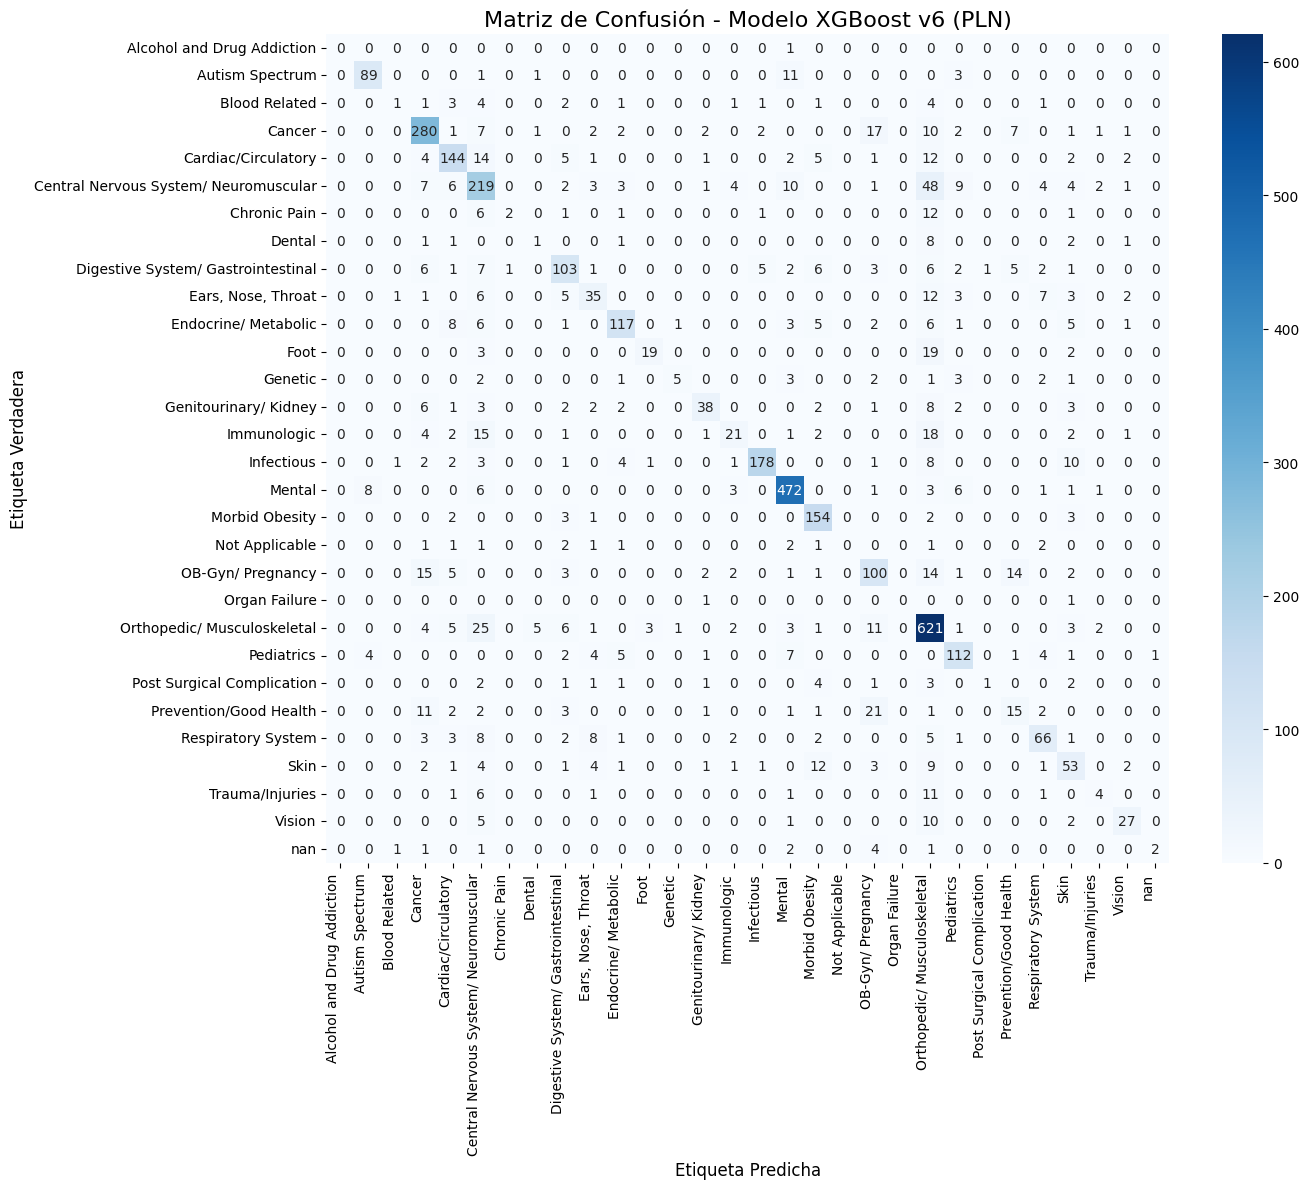

In [11]:
# --- PASO 8: EVALUACIÓN DEL MODELO ---
print("\n>>> Evaluando el modelo final...")
y_pred = xgb_classifier.predict(X_test_combined)
y_pred_proba = xgb_classifier.predict_proba(X_test_combined)

# Métricas básicas
accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión del modelo XGBoost en texto: {accuracy * 100:.2f}%")

# Métricas adicionales
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Precisión (Weighted): {precision * 100:.2f}%")
print(f"Recall (Weighted): {recall * 100:.2f}%")
print(f"F1-Score (Weighted): {f1 * 100:.2f}%")

print("\n--- Reporte de Clasificación ---")
# Fix: Convert class names to strings to handle any NaN or float values
class_names = [str(name) for name in diagnosis_encoder.classes_]
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

print("\n--- Matriz de Confusión ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - Modelo XGBoost v6 (PLN)', fontsize=16)
plt.ylabel('Etiqueta Verdadera', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

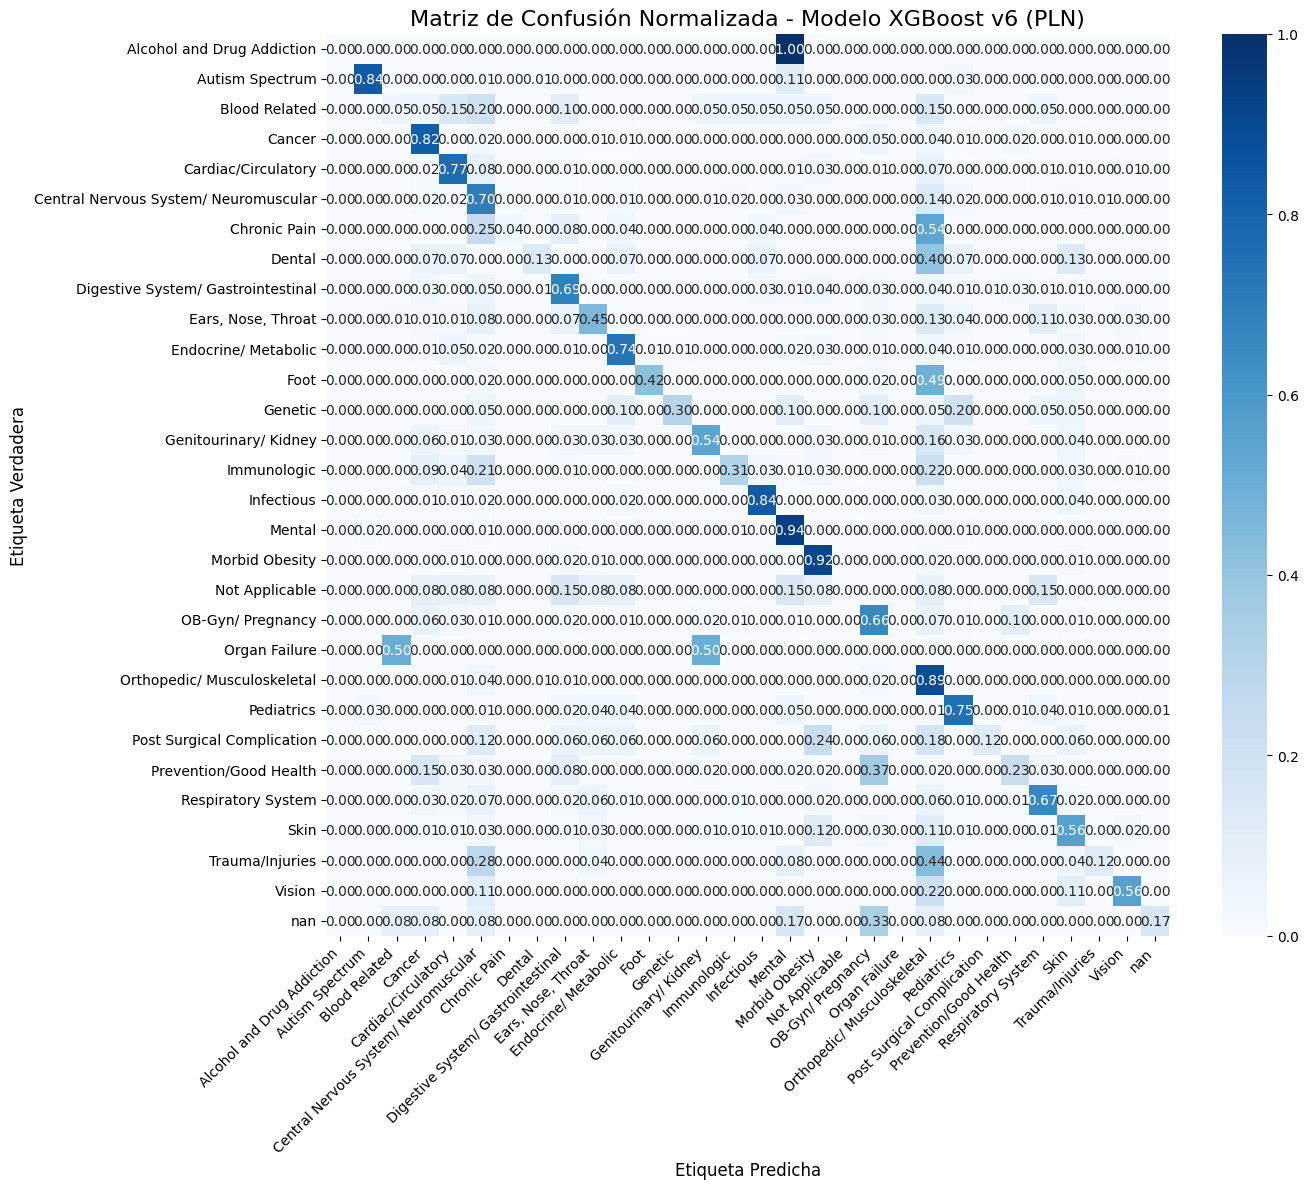

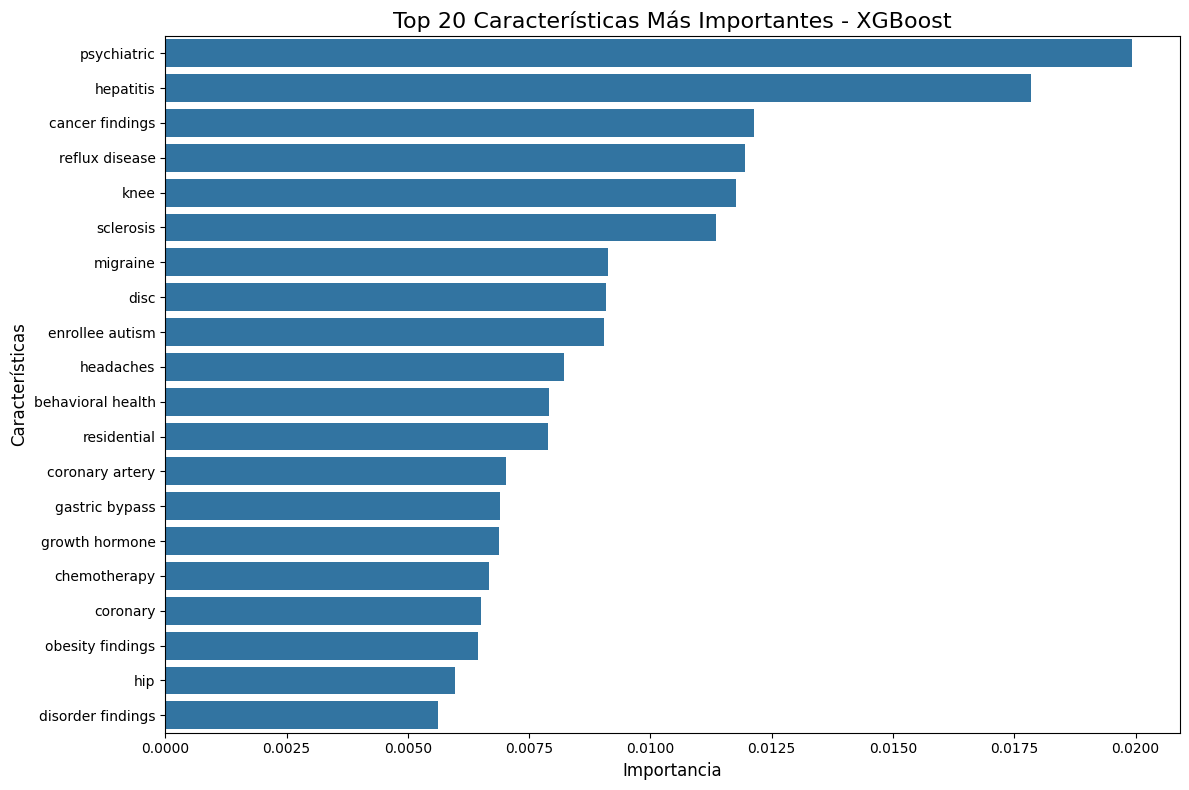


>>> Top 10 características más importantes:
 1. psychiatric: 0.0199
 2. hepatitis: 0.0178
 3. cancer findings: 0.0121
 4. reflux disease: 0.0119
 5. knee: 0.0118
 6. sclerosis: 0.0114
 7. migraine: 0.0091
 8. disc: 0.0091
 9. enrollee autism: 0.0090
10. headaches: 0.0082


In [ ]:
# Matriz de confusión normalizada
plt.figure(figsize=(14, 12))
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión Normalizada - Modelo XGBoost v6 (PLN)', fontsize=16)
plt.ylabel('Etiqueta Verdadera', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Feature importance (top 20 características más importantes)
feature_names = tfidf_vectorizer.get_feature_names_out().tolist() + ['Age_Range', 'Gender']
feature_importance = xgb_classifier.feature_importances_

# Crear DataFrame para mejor visualización
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
sns.barplot(data=top_features, x='importance', y='feature')
plt.title('Top 20 Características Más Importantes - XGBoost', fontsize=16)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Características', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\n>>> Top 10 características más importantes:")
for i, (feature, importance) in enumerate(importance_df.head(10).values):
    print(f"{i+1:2d}. {feature}: {importance:.4f}")

In [12]:
# --- PASO 9: GUARDADO DEL MODELO Y COMPONENTES ---
print("\n>>> Guardando el modelo v6 y los componentes...")
# Guardar el modelo entrenado
with open('modelo_diagnostico_v6_xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_classifier, f)

# Guardar los preprocesadores (muy importante para producción)
with open('preprocesadores_v6.pkl', 'wb') as f:
    pickle.dump({
        'tfidf_vectorizer': tfidf_vectorizer,
        'age_encoder': age_encoder,
        'gender_encoder': gender_encoder,
        'diagnosis_encoder': diagnosis_encoder
    }, f)

print(">>> ¡Modelo v6 y preprocesadores guardados exitosamente!")


>>> Guardando el modelo v6 y los componentes...
>>> ¡Modelo v6 y preprocesadores guardados exitosamente!


In [ ]:
# --- PASO 10: FUNCIÓN DE PREDICCIÓN Y EJEMPLOS ---
print("\n>>> Creando función de predicción...")

def predecir_diagnostico(texto_findings, edad_rango, genero_paciente):
    """
    Función para predecir la categoría de diagnóstico basada en:
    - texto_findings: Texto de los hallazgos médicos
    - edad_rango: Rango de edad del paciente (ej: '18-39', '40-64', etc.)
    - genero_paciente: Género del paciente ('Male', 'Female', etc.)

    Retorna: La categoría de diagnóstico predicha
    """
    try:
        # 1. Preprocesar el texto
        texto_limpio = preprocess_text(texto_findings)

        # 2. Vectorizar el texto con TF-IDF
        texto_tfidf = tfidf_vectorizer.transform([texto_limpio])

        # 3. Codificar las variables categóricas
        # Manejar valores desconocidos
        if edad_rango not in age_encoder.classes_:
            print(f"ADVERTENCIA: Edad '{edad_rango}' no reconocida. Usando 'Unknown'")
            edad_rango = 'Unknown'

        if genero_paciente not in gender_encoder.classes_:
            print(f"ADVERTENCIA: Género '{genero_paciente}' no reconocido. Usando 'Unknown'")
            genero_paciente = 'Unknown'

        edad_encoded = age_encoder.transform([edad_rango])
        genero_encoded = gender_encoder.transform([genero_paciente])

        # 4. Combinar características
        caracteristicas_categoricas = np.array([[edad_encoded[0], genero_encoded[0]]])
        caracteristicas_combinadas = hstack([texto_tfidf, caracteristicas_categoricas])

        # 5. Hacer predicción
        prediccion_encoded = xgb_classifier.predict(caracteristicas_combinadas)
        probabilidades = xgb_classifier.predict_proba(caracteristicas_combinadas)

        # 6. Decodificar la predicción
        categoria_predicha = diagnosis_encoder.inverse_transform(prediccion_encoded)[0]
        confianza = max(probabilidades[0]) * 100

        # 7. Obtener las top 3 predicciones
        top_indices = np.argsort(probabilidades[0])[::-1][:3]
        top_categorias = []
        for i in top_indices:
            categoria = diagnosis_encoder.inverse_transform([i])[0]
            prob = probabilidades[0][i] * 100
            top_categorias.append((categoria, prob))

        return {
            'categoria_principal': categoria_predicha,
            'confianza': confianza,
            'top_3_predicciones': top_categorias,
            'texto_procesado': texto_limpio
        }

    except Exception as e:
        return f"Error en la predicción: {e}"


>>> Creando función de predicción...


In [ ]:
# --- EJEMPLOS DE PREDICCIÓN ---
print("\n>>> Ejemplos de predicción:")

# Ejemplo 1: Caso cardiológico
print("\n=== EJEMPLO 1: Caso Cardiológico ===")
resultado1 = predecir_diagnostico(
    texto_findings="Patient presents with chest pain, shortness of breath, and elevated cardiac enzymes. ECG shows ST elevation in leads II, III, aVF indicating inferior wall myocardial infarction.",
    edad_rango="40-64",
    genero_paciente="Male"
)

print(f"Predicción principal: {resultado1['categoria_principal']}")
print(f"Confianza: {resultado1['confianza']:.2f}%")
print("Top 3 predicciones:")
for i, (categoria, prob) in enumerate(resultado1['top_3_predicciones'], 1):
    print(f"  {i}. {categoria}: {prob:.2f}%")

# Ejemplo 2: Caso ortopédico
print("\n=== EJEMPLO 2: Caso Ortopédico ===")
resultado2 = predecir_diagnostico(
    texto_findings="Patient reports severe back pain radiating to left leg. MRI shows herniated disc at L4-L5 level with nerve compression. Loss of sensation in left foot.",
    edad_rango="40-64",
    genero_paciente="Female"
)

print(f"Predicción principal: {resultado2['categoria_principal']}")
print(f"Confianza: {resultado2['confianza']:.2f}%")
print("Top 3 predicciones:")
for i, (categoria, prob) in enumerate(resultado2['top_3_predicciones'], 1):
    print(f"  {i}. {categoria}: {prob:.2f}%")

# Ejemplo 3: Caso neurológico
print("\n=== EJEMPLO 3: Caso Neurológico ===")
resultado3 = predecir_diagnostico(
    texto_findings="Patient experiencing frequent headaches, dizziness, and memory problems. CT scan reveals no acute findings. Symptoms worsen with stress and lack of sleep.",
    edad_rango="25-39",
    genero_paciente="Female"
)

print(f"Predicción principal: {resultado3['categoria_principal']}")
print(f"Confianza: {resultado3['confianza']:.2f}%")
print("Top 3 predicciones:")
for i, (categoria, prob) in enumerate(resultado3['top_3_predicciones'], 1):
    print(f"  {i}. {categoria}: {prob:.2f}%")

# Mostrar información adicional sobre los encoders
print("\n=== INFORMACIÓN DEL MODELO ===")
print(f"Categorías de diagnóstico disponibles: {len(diagnosis_encoder.classes_)}")
print(f"Rangos de edad disponibles: {list(age_encoder.classes_)}")
print(f"Géneros disponibles: {list(gender_encoder.classes_)}")
print(f"Características TF-IDF: {len(tfidf_vectorizer.get_feature_names_out())}")

# Función para predicción interactiva (opcional)
def prediccion_interactiva():
    """
    Función para hacer predicciones de forma interactiva
    """
    print("\n=== PREDICCIÓN INTERACTIVA ===")
    print("Ingresa los datos del paciente:")

    findings = input("Hallazgos médicos (en inglés): ")
    edad = input(f"Rango de edad {list(age_encoder.classes_)}: ")
    genero = input(f"Género {list(gender_encoder.classes_)}: ")

    resultado = predecir_diagnostico(findings, edad, genero)

    print(f"\n--- RESULTADO ---")
    print(f"Predicción: {resultado['categoria_principal']}")
    print(f"Confianza: {resultado['confianza']:.2f}%")
    print("Alternativas:")
    for i, (categoria, prob) in enumerate(resultado['top_3_predicciones'], 1):
        print(f"  {i}. {categoria}: {prob:.2f}%")

print("\n>>> Función de predicción creada exitosamente!")
print(">>> Puedes usar predecir_diagnostico() para nuevas predicciones")
print(">>> O ejecutar prediccion_interactiva() para modo interactivo")


>>> Ejemplos de predicción:

=== EJEMPLO 1: Caso Cardiológico ===
ADVERTENCIA: Edad '40-64' no reconocida. Usando 'Unknown'
Predicción principal: Cardiac/Circulatory
Confianza: 91.81%
Top 3 predicciones:
  1. Cardiac/Circulatory: 91.81%
  2. Orthopedic/ Musculoskeletal: 2.07%
  3. Central Nervous System/ Neuromuscular: 2.06%

=== EJEMPLO 2: Caso Ortopédico ===
ADVERTENCIA: Edad '40-64' no reconocida. Usando 'Unknown'
Predicción principal: Orthopedic/ Musculoskeletal
Confianza: 93.90%
Top 3 predicciones:
  1. Orthopedic/ Musculoskeletal: 93.90%
  2. Foot: 1.97%
  3. Central Nervous System/ Neuromuscular: 1.72%

=== EJEMPLO 3: Caso Neurológico ===
ADVERTENCIA: Edad '25-39' no reconocida. Usando 'Unknown'
Predicción principal: Central Nervous System/ Neuromuscular
Confianza: 78.29%
Top 3 predicciones:
  1. Central Nervous System/ Neuromuscular: 78.29%
  2. Respiratory System: 9.91%
  3. Orthopedic/ Musculoskeletal: 2.25%

=== INFORMACIÓN DEL MODELO ===
Categorías de diagnóstico disponibl